In [9]:
import warnings

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import (
    MaxAbsScaler,
    Normalizer,
    OneHotEncoder,
    RobustScaler,
    StandardScaler,
)

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

warnings.filterwarnings("ignore")


In [10]:
# Reading data___set
df = pd.read_csv("train.csv")
df_ = pd.read_csv("test.csv")
df.rename(
    columns={"required_doughnuts_comsumption": "doughnuts_comsumption"}, inplace=True
)

In [11]:
# replaceing missing values
for column in df_.columns:
    df[column] = df[column].fillna(f"missing{column}")
    df_[column] = df_[column].fillna(f"missing{column}")


In [12]:
def split(location):
    l = location.split(",")
    return l[0]

df["country"] = df.location.apply(split)
df_["country"] = df.location.apply(split)

In [13]:
# concatinating the text features
text_cols = [
    "title",
    "location",
    "department",
    "salary_range",
    "company_profile",
    "requirements",
    "benefits",
    "employment_type",
    "required_experience",
    "required_education",
    "industry",
    "function",
    "country",
]

for column in text_cols:
    df["description"] += " " + df[column]
    df_["description"] += " " + df_[column]

In [14]:
# special characters \r and \n
df["Content_Parsed_1"] = df["description"].str.replace("\r", " ")
df["Content_Parsed_1"] = df["Content_Parsed_1"].str.replace("\n", " ")
df["Content_Parsed_1"] = df["Content_Parsed_1"].str.replace("    ", " ")
df["Content_Parsed_1"] = df["Content_Parsed_1"].str.replace('"', "")

df_["Content_Parsed_1"] = df_["description"].str.replace("\r", " ")
df_["Content_Parsed_1"] = df_["Content_Parsed_1"].str.replace("\n", " ")
df_["Content_Parsed_1"] = df_["Content_Parsed_1"].str.replace("    ", " ")
df_["Content_Parsed_1"] = df_["Content_Parsed_1"].str.replace('"', "")


In [15]:
# lowercasing the text
df["Content_Parsed_2"] = df["Content_Parsed_1"].str.lower()
df_["Content_Parsed_2"] = df_["Content_Parsed_1"].str.lower()

In [16]:
punctuations = string.punctuation
df["Content_Parsed_3"] = df["Content_Parsed_2"]
df_["Content_Parsed_3"] = df_["Content_Parsed_2"]

for punct_sign in punctuations:
    df["Content_Parsed_3"] = df["Content_Parsed_3"].str.replace(punct_sign, "")
    df_["Content_Parsed_3"] = df_["Content_Parsed_3"].str.replace(punct_sign, "")

In [17]:
df["Content_Parsed_4"] = df["Content_Parsed_3"].str.replace("'s", "")
df_["Content_Parsed_4"] = df_["Content_Parsed_3"].str.replace("'s", "")


In [18]:
# Downloading punkt and wordnet from NLTK
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
stop_words = list(stopwords.words("english"))

[nltk_data] Downloading package punkt to /home/zozoka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/zozoka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zozoka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
wordnet_lemmatizer = WordNetLemmatizer()
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    lemmatized_list = []
    text = df.loc[row]["Content_Parsed_4"]
    text_words = text.split(" ")

    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))

    lemmatized_text = " ".join(lemmatized_list)
    lemmatized_text_list.append(lemmatized_text)

nrows_ = len(df_)
lemmatized_text_list_ = []

for row in range(0, nrows_):
    lemmatized_list = []
    text = df_.loc[row]["Content_Parsed_4"]
    text_words = text.split(" ")

    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))

    lemmatized_text = " ".join(lemmatized_list)
    lemmatized_text_list_.append(lemmatized_text)

In [20]:
df["Content_Parsed_5"] = lemmatized_text_list
df_["Content_Parsed_5"] = lemmatized_text_list_

In [21]:
df["Content_Parsed_6"] = df["Content_Parsed_5"]
df_["Content_Parsed_6"] = df_["Content_Parsed_5"]

for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df["Content_Parsed_6"] = df["Content_Parsed_6"].str.replace(regex_stopword, "")
    df_["Content_Parsed_6"] = df_["Content_Parsed_6"].str.replace(regex_stopword, "")


In [22]:
df["description"] = df["Content_Parsed_6"].replace("’", "")
df["description"].apply(lambda x: re.sub("(email)|(url)\w+", "", x))
df["description"].apply(lambda x: re.sub("\w*\d\w*", "", x))

df_["description"] = df_["Content_Parsed_6"].replace("’", "")
df_["description"].apply(lambda x: re.sub("(email)|(url)\w+", "", x))
df_["description"].apply(lambda x: re.sub("\w*\d\w*", "", x))


0         several open available   area offer  competi...
1        call center representative   provide  sociall...
2       tpg  search  chief accountant  one   business ...
3        office service associate   base   san jose ca...
4       oracle fusion hcm resourcelocation  north cant...
                              ...                        
7147     uswe take  hassle   find  book  cleaner onlin...
7148      qa engineer    responsible  lead  quality as...
7149     urgently require  day  night trunkers run   a...
7150    experience firmware engineer  require  respons...
7151      fantastic opportunity  someone want  start  ...
Name: description, Length: 7152, dtype: object

In [23]:
df["text_len"] = df["description"].str.len()
df_["text_len"] = df_["description"].str.len()

In [24]:
word_vectorizer = TfidfVectorizer(
    encoding="utf-8",
    ngram_range=(1, 2),
    stop_words=None,
    lowercase=False,
    max_df=10,
    min_df=1,
    max_features=8000,
    norm="l2",
    sublinear_tf=True,
)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents="unicode",
    analyzer="char",
    ngram_range=(1, 4),
    dtype=np.float32,
    max_features=8000,
)

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]


In [26]:
str_features = "description"
cat_features = ["country", "has_company_logo", "has_questions", "telecommuting"]
num_features = [  #'num',
    #'doughnuts_comsumption',
    "text_len",
    "job_id",
    #'word_counts',
    #'characters_per_word'
]


In [27]:
text_word = Pipeline(
    [("selector", DataFrameSelector(str_features)), ("vectorizer", word_vectorizer)]
)
text_char = Pipeline(
    [("selector", DataFrameSelector(str_features)), ("vectorizer", char_vectorizer)]
)

text = FeatureUnion([("text_word", text_word), ("text_char", text_char)])

In [28]:
num_feats = Pipeline(
    [
        ("selector", DataFrameSelector(num_features)),
        # ('standard', StandardScaler())
    ]
)

In [29]:
cat_feats = Pipeline(
    [
        ("selector", DataFrameSelector(cat_features)),
        ("encode", OneHotEncoder(handle_unknown="ignore")),
    ]
)

In [30]:
feats = FeatureUnion(
    [("text", text), ("num_feats", num_feats), ("cat_feats", cat_feats)]
)

In [31]:
pickle.dump(df, open("data_clean.pkl", "wb"))

In [32]:
y = df["fraudulent"]
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
X_ = df_

In [33]:
clf = LinearSVC()

# Create pipeline 
pipe = imbPipeline(
    [
        ("features", feats),
        ("standard", StandardScaler(with_mean=False)),
        ("selector", SelectFromModel(estimator=LinearSVC())),
        ("SMOTE", SMOTE()),
        ("classifier", clf),
    ]
)

# fitting our model.
pipe.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 FeatureUnion(transformer_list=[('text_word',
                                                                                 Pipeline(steps=[('selector',
                                                                                                  DataFrameSelector(attribute_names='description')),
                                                                                                 ('vectorizer',
                                                                                                  TfidfVectorizer(lowercase=False,
                                                                                                                  max_df=10,
                                                                                                                  max_features=8000,
                                                            

In [34]:
pickle.dump(pipe, open("model.pkl", "wb"))

In [35]:
predicted_LinearSVC = pipe.predict(X_test)
np.sum(predicted_LinearSVC)

81

In [36]:
predicted_LinearSVC_X_ = pipe.predict(X_)
np.sum(predicted_LinearSVC_X_)

273

In [37]:
file = pd.DataFrame(predicted_LinearSVC_X_)
file.index.name = "Id"
file.to_csv("pred_LinearSVC.csv", index=True, header=["Category"])

In [38]:
# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted_LinearSVC))
print("Logistic Regression Recall:", recall_score(y_test, predicted_LinearSVC))
print(roc_auc_score(y_test, predicted_LinearSVC))
print(classification_report(y_test, predicted_LinearSVC))
print(f"confusion_matrix:\n {confusion_matrix(y_test,predicted_LinearSVC)}")

Logistic Regression Accuracy: 0.9822926374650512
Logistic Regression Recall: 0.7047619047619048
0.8506661067170622
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2041
           1       0.91      0.70      0.80       105

    accuracy                           0.98      2146
   macro avg       0.95      0.85      0.89      2146
weighted avg       0.98      0.98      0.98      2146

confusion_matrix:
 [[2034    7]
 [  31   74]]


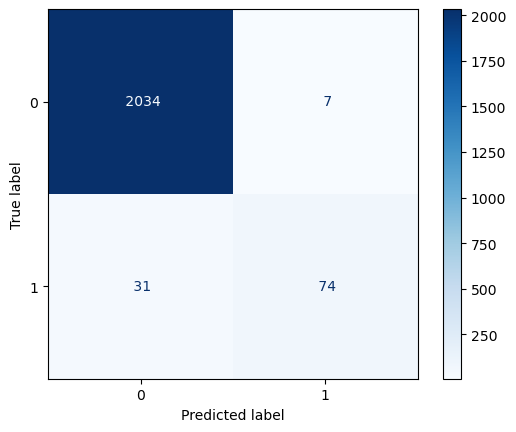

In [39]:
plot_confusion_matrix(pipe, X_test, y_test, cmap="Blues", values_format=" ")

In [ ]:
parameters = {
    #'classifier__class_weight' : ['none', 'balanced', '{0:1, 1:10}'],
    #'classifier__penalty' : ['l1','l2'],
    #'classifier__C'       : np.logspace(-4,4,9),
    #'classifier__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    "classifier__C": np.logspace(-4, 4, 9),
    "classifier__tol": [1, 0.1, 0.01],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

clf_GS = GridSearchCV(pipe, parameters, cv=2, n_jobs=4, verbose=1)
clf_GS.fit(X_train, y_train)

In [ ]:
print("Tuned Hyperparameters :", clf_GS.best_params_)
print("Accuracy :", clf_GS.best_score_)